# Рекомендация тарифов

В распоряжении данные о поведении клиентов, которые уже перешли на определенные тарифы (из данных одного из предыдущих проектов). Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построить модель с максимально большим значением *accuracy*. Требуется довести долю правильных ответов до 0.75. Проверить *accuracy* на тестовой выборке.

## Изучение файла

In [1]:
# Импорт библиотеки pandas
import pandas as pd
# Импорт библиотеки numpy
import numpy as np
# Импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# Импорт библиотеки math
import math
# Импорт библиотеки seaborn
import seaborn as sns
# Импорт библиотеки sklearn и необходимых компонентов
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
# Удаление ложных предупреждений
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Загрузка таблицы в память переменной df типа dataframe
df = pd.read_csv('/datasets/users_behavior.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df.head())
print('Количество явных дубликатов', df.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
 ----- Информация о заголовках полей dataframe ----- 
Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 Импортированы все библиотеки, используемые далее в проекте, и скорректированы настройки <br>
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Отсутствует необходимость в редактировании заголовков, названия представлены в условно общепринятом формате 'Змеиный регистр'
2. Отсутствуют пропуски и явные дубликаты
3. Тип данных некоторых числовых полей, необходимость отображения значений в виде дробных или целых чисел у которых отсутствует, необходимо преобразовать, в дальнейшем можно уменьшить объем памяти для хранения данных
4. В данных таблицы некорректные значения не наблюдаются. Необходимо будет детально рассмотреть параметры каждого столбца
5. Необходимо проверить, присутствуют ли ненужные записи с отсутствующими данными, например, пользователей, не использовавших функционал, предоставляемый тарифом, или неактуальные данные еще не подключившихся пользователей
</font> 

In [3]:
print('Количество записей без необходимых данных для последующего анализа:', df[(df['calls'] == 0) & (df['minutes'] == 0) & (df['messages'] == 0) & (df['mb_used'] == 0)]['is_ultra'].count())
for i in df:
    print(i)
    print(df[df[i] == 0][i].count())

Количество записей без необходимых данных для последующего анализа: 0
calls
40
minutes
40
messages
497
mb_used
11
is_ultra
2229


<font color='DarkBlue'> 
📌 Все записи актуальны, имеют полезную информацию, их удаление не требуется. Записей с нулевыми значениями показателей использования услуг оператора связи достаточно мало за исключением менее популярной услуги отправки сообщений, что является адекватным показателем <br>
📌 Далее необходимо выполнить преобразование типов данных, если присутствует подобная возможность <br>
</font> 

In [4]:
if len(df['is_ultra'].unique()) == 2:
    df['is_ultra'] = df['is_ultra'].astype('bool')
for i in df.select_dtypes(include=['float']):
    if df[df[i] % 1 > 0][i].count() == 0:
        df[i] = df[i].astype('int')
df[df.select_dtypes(include=['int']).columns] = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[df.select_dtypes(include=['float']).columns] = df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   uint8  
 1   minutes   3214 non-null   float32
 2   messages  3214 non-null   uint8  
 3   mb_used   3214 non-null   float32
 4   is_ultra  3214 non-null   bool   
dtypes: bool(1), float32(2), uint8(2)
memory usage: 34.7 KB


<font color='DarkBlue'> 
📌 Теперь необходимо детально рассмотреть параметры каждого столбца и построить гистограммы распределения <br>
</font> 

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208771,38.281269,17207.673828
std,33.236368,234.569870,36.148326,7570.968262
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.574997,9.000000,12491.902588
50%,62.000000,430.600006,30.000000,16943.234375
75%,82.000000,571.927521,57.000000,21424.699707
max,244.000000,1632.060059,224.000000,49745.730469


,is_ultra
count,3214
unique,2
top,False
freq,2229


-----
False    2229
True      985
Name: is_ultra, dtype: int64
-----
calls


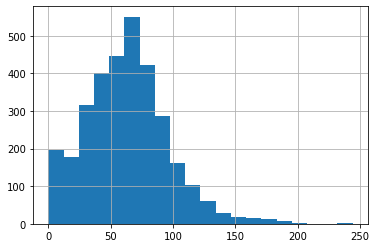

minutes


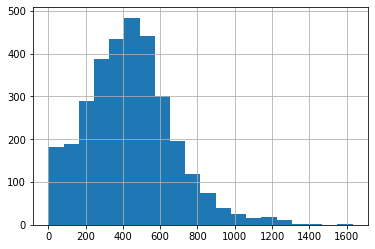

messages


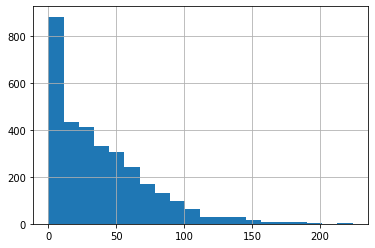

mb_used


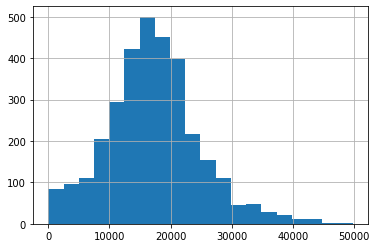

is_ultra


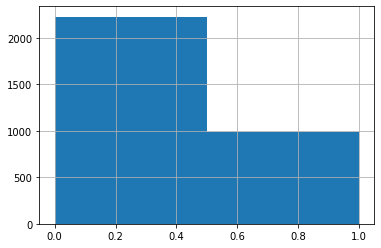

In [5]:
display(df.describe())
try:
    display(df.describe(include = ['object','bool','datetime']))
    for i in df.select_dtypes(include=['object','bool','datetime']):
        print('-----')
        if df[i].count() != len(df[i].unique()):
            print(df[i].value_counts())
        else:
            print('Все значения уникальны')
except:
    print('Все данные представлены в числовом формате')
print('-----')
for i in df:   
    print(i)
    if i in df.select_dtypes(include=['bool']):
        df[i].astype('int').hist(bins=2)
        plt.show()  
    else:        
        df[i].hist(bins=20)
        plt.show()

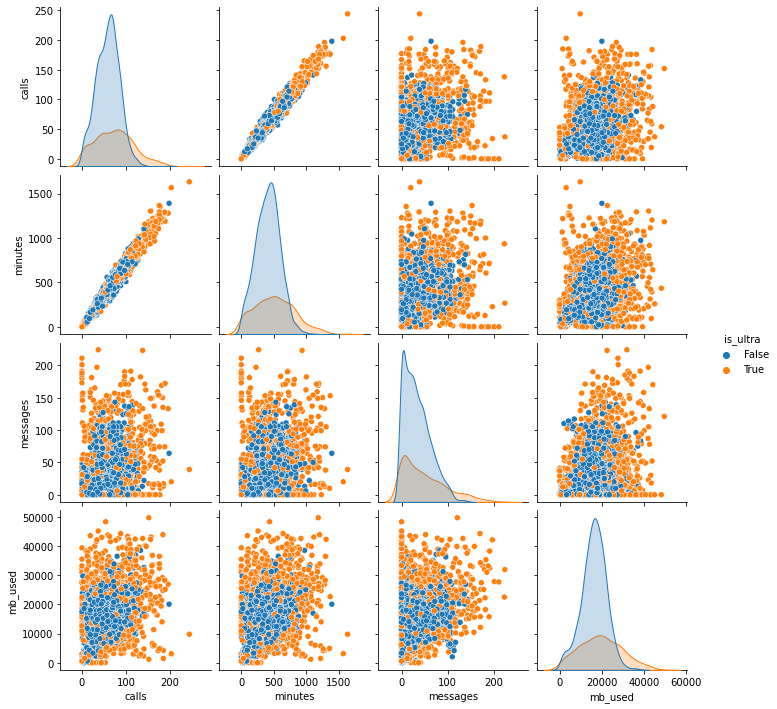

In [6]:
sns.pairplot(df, hue='is_ultra')

<font color='DarkBlue'> 
📌 Данные о распределении пользования услугами тарифов поддаются адекватной логике. Типы данных преобразованы в соответствующий тип. Первичная предобработка завершена, можно продолжать работу с преобразованной таблицей <br>
</font> 

## Разбивка данных на выборки

<font color='DarkBlue'> 
📌 Необходимо создать наиболее точную модель для оценки пользователей, использующих тот или иной тариф, по полученному датасету <br>    
📌 Сначала необходимо разделить исходный набор данных на два: с признаками для обучения модели и целевым признаком для его определения, затем разбить полученные выборки на обучающую, валидационную и тестовую, исходя из общепринятого соотношения 60-20-20 и проверить их размеры <br>
</font> 

In [7]:
df_features = df.drop('is_ultra', axis=1)
df_target = df['is_ultra']
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_features, df_target, test_size=0.4, random_state=12345)
df_features_valid, df_features_test, df_target_valid, df_target_test = train_test_split(df_features_valid, df_target_valid, test_size=0.5, random_state=12345)
print(df_features_train.shape)
print(df_target_train.shape)
print(df_features_valid.shape)
print(df_target_valid.shape)
print(df_features_test.shape)
print(df_target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


<font color='DarkBlue'> 
📌 Необходимые данные получены в соответствии с заданными условиями <br>    
</font> 

## Исследование модели

<font color='DarkBlue'> 
📌 В данном случае необходимо использовать алгоритмы классификации для создания модели, так как ключевым целевым признаком является качественный параметр, имеющий 2 варианта значений: True или False <br>      
📌 Можно обучить модель в соответствии с алгоритмом 'Решающее дерево', используя в качестве гиперпараметров 2 основных вида критериев и изменяемую глубину дерева от 1 до 10, и определить наилучшее наибольшее значение 'accuracy' на валидационной выборке для подобного алгоритма. Затем можно определить результат параметра лучшей модели на тестовой выборке <br>    
</font>

In [8]:
best_result = 0
for depth in range(1, 11):
    for kind in ['gini', 'entropy']: 
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion = kind) # подготовлена модель с заданной глубиной дерева
        model.fit(df_features_train, df_target_train) # обучена модель на тренировочной выборке
    #    predictions = model.predict(df_features_valid) # получены предсказания модели
    #    result = accuracy_score(df_target_valid, predictions) # рассчитано качество модели на валидационной выборке
        result = model.score(df_features_valid, df_target_valid) # рассчитано качество модели на валидационной выборке
        if result > best_result:
            best_model = model # сохранена наилучшая модель
            best_result = result  # сохранено наилучшее значение метрики accuracy на валидационных данных
            best_depth = depth
            best_criterion = kind
print('Accuracy наилучшей модели на валидационной выборке:', best_result, '- Максимальная глубина:', best_depth, '- Критерий', best_criterion)
print('Accuracy определенной модели на обучающей выборке:', best_model.score(df_features_train, df_target_train))
print('Accuracy определенной модели на тестовой выборке:', best_model.score(df_features_test, df_target_test))

Accuracy наилучшей модели на валидационной выборке: 0.7853810264385692 - Максимальная глубина: 3 - Критерий gini
Accuracy определенной модели на обучающей выборке: 0.8075726141078838
Accuracy определенной модели на тестовой выборке: 0.7791601866251944


<font color='DarkBlue'> 
📌 Получены значения гиперпараметров модели и ее параметр 'accuracy' для сравнения с соответствующими результатами следующих моделей, использующих указанные далее алгоритмы обучения и предсказания. Их значения в пределах предполагаемой нормы, модель не недообучена и не переобучена <br>      
📌 Далее можно обучить модель с помощью алгоритма 'Случайный лес', используя в качестве гиперпараметров 2 основных вида критериев, изменяемую глубину дерева от 1 до 10 и их количество от 1 до 51 с шагом 10. Затем предполагается также определить наибольшее значение 'accuracy' на валидационной выборке для подобного алгоритма и после его обозначения на тестовой <br>    
</font>

In [9]:
best_result = 0
for est in range(1, 51, 10):
    for depth in range(1, 11):
        for kind in ['gini', 'entropy']: 
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, criterion = kind)
            model.fit(df_features_train, df_target_train)
            result = model.score(df_features_valid, df_target_valid)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_criterion = kind
print('Accuracy наилучшей модели на валидационной выборке:', best_result, '- Количество деревьев:', best_est, '- Максимальная глубина:', best_depth, '- Критерий', best_criterion)
print('Accuracy определенной модели на обучающей выборке:', best_model.score(df_features_train, df_target_train))
print('Accuracy определенной модели на тестовой выборке:', best_model.score(df_features_test, df_target_test))

Accuracy наилучшей модели на валидационной выборке: 0.807153965785381 - Количество деревьев: 21 - Максимальная глубина: 6 - Критерий entropy
Accuracy определенной модели на обучающей выборке: 0.8366182572614108
Accuracy определенной модели на тестовой выборке: 0.7978227060653188


<font color='DarkBlue'> 
📌 Получены значения гиперпараметров модели и ее параметр 'accuracy'. Он выше, чем у наилучшей предыдущей модели, есть небольшое абсолютно некритичное отклонение в сторону переобучения <br>      
📌 И можно обучить модель с помощью алгоритма 'Логистическая регрессия', используя в качестве гиперпараметра 2 основных способа исполнения алгоритма и определить наилучшее значение 'accuracy' на валидационной и тестовой выборках <br>    
</font>

In [10]:
best_result = 0
for algorithm in ['lbfgs', 'liblinear']:
    model = LogisticRegression(random_state=12345, solver=algorithm, max_iter=1000) 
    model.fit(df_features_train, df_target_train)
    result = model.score(df_features_valid, df_target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_solver = algorithm
print('Accuracy модели:', best_result, '- Алгоритм', best_solver)
print('Accuracy определенной модели на обучающей выборке:', best_model.score(df_features_train, df_target_train))
print('Accuracy определенной модели на тестовой выборке:', best_model.score(df_features_test, df_target_test))

Accuracy модели: 0.7107309486780715 - Алгоритм lbfgs
Accuracy определенной модели на обучающей выборке: 0.7131742738589212
Accuracy определенной модели на тестовой выборке: 0.6842923794712286


<font color='DarkBlue'> 
📌 Получены значение гиперпараметра модели и ее ключевой параметр 'accuracy'. Он ниже, чем у моделей предыдущих алгоритмов, поэтому этот способ обучения в данном примере далее рассматривать не следует <br> 
📌 Наилучшей и наиболее точно прогнозирующей моделью является построенная с помощью алгоритма классификации 'Случайный лес', отличающийся меньшим быстродействием ее определения <br>    
</font>

In [11]:
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier(random_state=12345)
parameters = {'criterion': ['gini', 'entropy'], 'n_estimators': range (1, 51, 10), 'max_depth': range (1, 11)}
# 'min_samples_leaf': range (1,8), 'min_samples_split': range (2,10,2) 
grid = GridSearchCV(model, parameters, cv=2)
grid.fit(df_features_train, df_target_train)
print('Лучшая модель:', grid.best_estimator_)
print('Параметры лучшей модели:', grid.best_params_)  
print('Лучшая точность:', grid.best_score_)    

Лучшая модель: RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=21,
                       random_state=12345)
Параметры лучшей модели: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 21}
Лучшая точность: 0.8200207468879668


In [12]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestClassifier(random_state=12345)
parameters = {'criterion': ['gini', 'entropy'], 'n_estimators': range (1, 51, 10), 'max_depth': range (1, 11)}
# 'min_samples_leaf': range (1,8), 'min_samples_split': range (2,10,2) 
grid = RandomizedSearchCV(model, parameters, cv=2)
grid.fit(df_features_train, df_target_train)
print('Лучшая модель:', grid.best_estimator_)
print('Параметры лучшей модели:', grid.best_params_)  
print('Лучшая точность:', grid.best_score_)   

Лучшая модель: RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=11,
                       random_state=12345)
Параметры лучшей модели: {'n_estimators': 11, 'max_depth': 10, 'criterion': 'entropy'}
Лучшая точность: 0.8091286307053942


## Проверка модели на тестовой выборке

<font color='DarkBlue'> 
📌 Для выделения лучшего решения и его результата можно снова проверить действие модели, обученной с помощью обучающей и валидационной ввыборок, на тестовой <br>   
</font>

In [13]:
df_features_train = pd.concat([df_features_train, df_features_valid])
df_target_train = pd.concat([df_target_train, df_target_valid])
print(df_features_train.shape)
print(df_target_train.shape)

(2571, 4)
(2571,)


In [14]:
model = RandomForestClassifier(random_state=12345, n_estimators=21, max_depth=6, criterion = 'entropy')
model.fit(df_features_train, df_target_train)
print('Accuracy лучшей модели на тестовой выборке:', model.score(df_features_test, df_target_test))

Accuracy лучшей модели на тестовой выборке: 0.7962674961119751


<font color='DarkBlue'> 
📌 Значение 'accuracy' немного меньше, чем у валидационной выборки, но больше, чем у других алгоритмов обучения, и является достаточно хорошим показателем <br> 
</font>

## Проверка модели на адекватность

<font color='DarkBlue'> 
📌 Также можно проверить модель на вменяемость (адекватность) <br> 
📌 Для модели, совершенно случайно определяющей показания независимого целевого признака, исходя из текущих данных, можно также определить параметр 'accuracy' подобно предыдущим расчетам по обучающей выборке, учитывая, что значения целевых признаков остальных выборок будут распределены в подобных долях. Для этого необходимо определить сумму произведений долей каждого из возможных значений целевого признака и вероятностей их случайного обнаружения, равной соответственно их доле <br>  
</font>

In [15]:
print('Accuracy случайной модели:', df_target_train.mean() ** 2 + (1 - df_target_train.mean()) ** 2)

Accuracy случайной модели: 0.5767051974412867


<font color='DarkBlue'> 
📌 Полученные ранее значения соответствующего парметра выше полученного, значит все являются адекватными <br> 
📌 Также для сравнения и проверки можно использовать значение 'accuracy' модели на валидационной выборке, обученной элементарным алгоритмом <br>  
</font>

In [16]:
model = DummyClassifier(random_state=12345)
model.fit(df_features_train, df_target_train)
print('Accuracy модели на валидационной выборке:', model.score(df_features_valid, df_target_valid))
print('Accuracy модели на тестовой выборке:', model.score(df_features_test, df_target_test))

Accuracy модели на валидационной выборке: 0.7060653188180405
Accuracy модели на тестовой выборке: 0.6842923794712286


<font color='DarkBlue'> 
📌 Параметр 'accuracy' для модели, обученной самым простым алгоритмом, также меньше рассчитанных ранее, поэтому можно полагать, что проверка модели на адекватность пройдена <br> 
📌 На основынии произведенных исследований можно сформировать следующие выводы: <br>   
    - предоставленные данные хорошего качества, для более удобного расчета необходимо преобразование типов данных в форматы, занимающие меньший объем памяти <br>
    - определено, что наилучшим алгоритмом обучения модели для подобных данных будет являться 'Случайный лес', так как количество верно определенных целевых признаков на тестовой выборке, выделенной из имеющихся исходных данных, больше, о чем свидетельствует наилучшее значение 'accuracy' среди остальных рассматриваемых алгоритмов. Все модели, полученные с помощью использованных алгоритмов обучения и прогнозирования, являются адекватными, соответственно, их выбор являлся корректным для сравнения, и их использование рационально для обучения модели по исходному датасету <br> 
</font>